# Churn analysis for Telco customers

To start, the necessary libraries are loaded.

In [ ]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, auc

## 1. Data exploration and pre-processing

The dataset has been obtained from [Kaggle](https://www.kaggle.com/blastchar/telco-customer-churn), and it consists in a collection of customers from a telco company. The goal is to predict whether a customer is leaving the company or not.

In [ ]:
!unzip "archive.zip" -d /content

Archive:  archive.zip
  inflating: /content/WA_Fn-UseC_-Telco-Customer-Churn.csv  


In [ ]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv", index_col = "customerID")
df.shape

(7043, 20)

The dataset contains over 7k observations and 20 variables. A brief summary of them is provided:

* `customerID`: customer ID, it is used as index column

* `gender`: whether the customer is a male or a female

* `SeniorCitizen`: whether the customer is a senior citizen or not (1, 0)

* `Partner`: whether the customer has a partner or not (Yes, No)

* `Dependents`: whether the customer has dependents or not (Yes, No)

* `tenure`: number of months the customer has stayed with the company

* `PhoneService`: whether the customer has a phone service or not (Yes, No)

* `MultipleLines`: whether the customer has multiple lines or not (Yes, No, No phone service)

* `InternetService`: customer’s internet service provider (DSL, Fiber optic, No)

* `OnlineSecurity`: whether the customer has online security or not (Yes, No, No internet service)

* `OnlineBackup`: whether the customer has online backup or not (Yes, No, No internet service)

* `DeviceProtection`: whether the customer has device protection or not (Yes, No, No internet service)

* `TechSupport`: whether the customer has tech support or not (Yes, No, No internet service)

* `StreamingTV`: whether the customer has streaming TV or not (Yes, No, No internet service)

* `StreamingMovies`: whether the customer has streaming movies or not (Yes, No, No internet service)

* `Contract`: the contract term of the customer (Month-to-month, One year, Two year)

* `PaperlessBilling`: whether the customer has paperless billing or not (Yes, No)

* `PaymentMethod`: the customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))

* `MonthlyCharges`: the amount charged to the customer monthly

* `TotalCharges`: the total amount charged to the customer

* `Churn`: whether the customer churned or not (Yes or No)

In [ ]:
df.head(15)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null 

There are not null values, therefore apparently imputation is not needed. Anyway, something is definitely not correct about `TotalCharges`, since the `Dtype` of this variable should be `float64`.

In [ ]:
df["TotalCharges"].value_counts()

           11
20.2       11
19.75       9
20.05       8
19.65       8
           ..
1382.9      1
149.05      1
3966.3      1
3450.15     1
447.9       1
Name: TotalCharges, Length: 6531, dtype: int64

It appears that 11 values are not null, since they consist in a white space and in fact they should be treated as missing values.

In [ ]:
df[df.TotalCharges == " "]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No


These customers are most likely the ones with value 0 for tenure.

In [ ]:
df[df.TotalCharges == " "].index == df[df.tenure == 0].index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

They are newly acquired customers, they never had any charges so those records are legitimately empty.

Imputation is needed and a value has to be put in place of the blank space, 0 is a reasonable choice, considering the nature of the variable.

In [ ]:
df.loc[df.TotalCharges == " ", "TotalCharges"] = 0

df["TotalCharges"] = df["TotalCharges"].astype(float)

Now that `TotalCharges` is not flawed anymore, histograms can be plotted for the three quantitative variables.

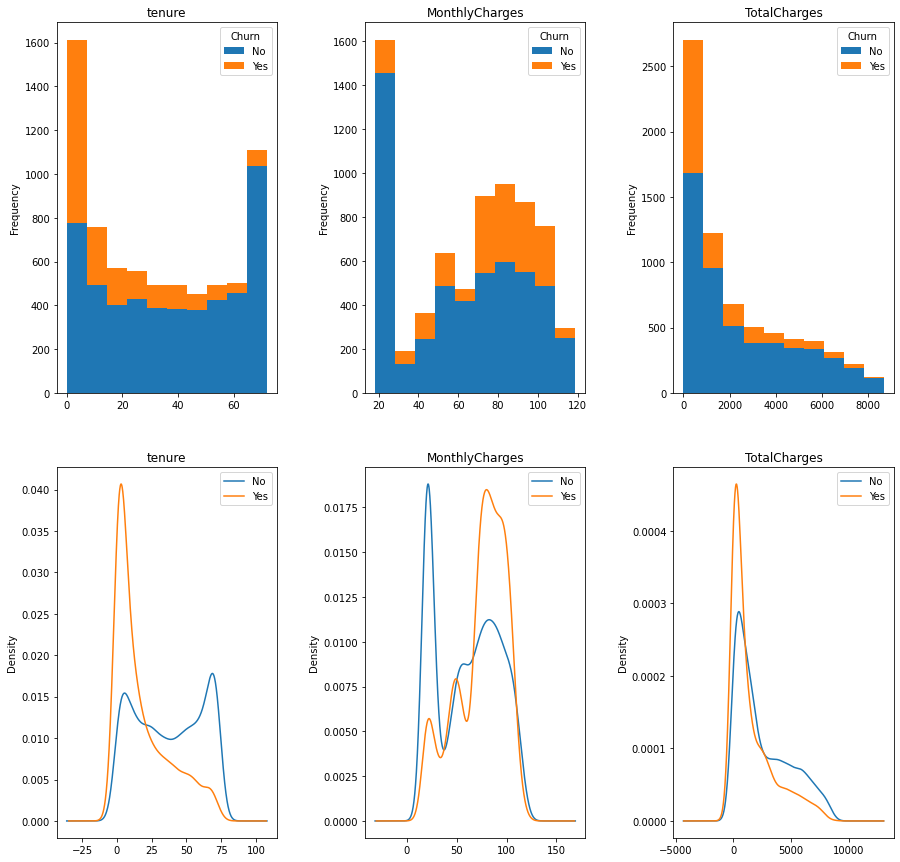

In [ ]:
fig, axes = plt.subplots(2, 3, figsize = (15, 15))

df.pivot(columns = "Churn", values = "tenure").plot(kind = "hist", legend = True, title = "tenure", stacked = True, ax = axes[0,0])
df.pivot(columns = "Churn", values = "MonthlyCharges").plot(kind = "hist", legend = True, title = "MonthlyCharges", stacked = True, ax = axes[0,1])
df.pivot(columns = "Churn", values = "TotalCharges").plot(kind = "hist", legend = True, title = "TotalCharges", stacked = True, ax = axes[0,2])

df.groupby("Churn").tenure.plot(kind="kde", legend = True, title = "tenure", ax = axes[1,0])
df.groupby("Churn").MonthlyCharges.plot(kind="kde", legend = True, title = "MonthlyCharges", ax = axes[1,1])
df.groupby("Churn").TotalCharges.plot(kind="kde", legend = True, title = "TotalCharges", ax = axes[1,2])

plt.subplots_adjust(wspace = 0.4)
plt.show()

`tenure` plot implies that leaving customers tend to quit the company within the first months, and that the remaining customers are more likely to stay for a longer timeframe and they are usually the most loyal (i.e. those who are still customers after several years).

`MonthlyCharges` shows that most of leaving customers tend to pay an amount in the range (70, 100), and the probability of paying a cheaper monthly fee is considerably higher for customers who doesn't churn, rather than those who does.

`TotalCharges`, on the other hand, has a decreasing behaviour for both leaving and remaining customers. Many customers leave even if they did not pay a conspicuous total amount, implying perhaps the company has a vast turn over.

In [ ]:
df[["tenure", "MonthlyCharges", "TotalCharges"]].corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.247900,0.826178
MonthlyCharges,0.247900,1.000000,0.651174
TotalCharges,0.826178,0.651174,1.000000


The correlation matrix shows a strong linear correlation between `tenure` and `MonthlyCharges`, and a significant linear correlation between `MonthlyCharges` and `TotalCharges`.

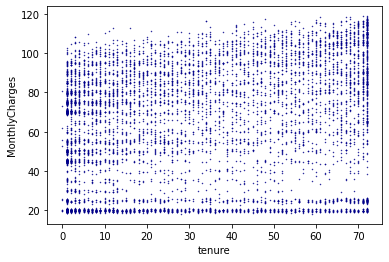

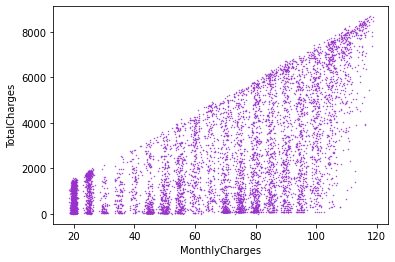

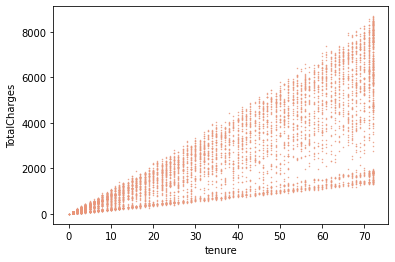

In [ ]:
df.plot.scatter(x = "tenure", y = "MonthlyCharges", color = "darkblue", s = 0.2)
df.plot.scatter(x = "MonthlyCharges", y = "TotalCharges", color = "darkorchid", s = 0.2)
df.plot.scatter(x = "tenure", y = "TotalCharges", color = "darksalmon", s = 0.2)
plt.show()

Plots basically confirm the numbers in the correlation matrix, and a sort of linear correlation is quite visible for the last two plots.

Talking about qualitative variables, some pre-processing is needed for them too. First of all, some of them are linked and, as a consequence, a few of them could be redundant.

In [ ]:
pd.crosstab(df["PhoneService"], df["MultipleLines"])

MultipleLines,No,No phone service,Yes
PhoneService,,,
No,0,682,0
Yes,3390,0,2971


All customers with value "No" for the `PhoneService` variable, have "No phone service" for the `MultipleLines` variable. Therefore, `MultipleLines` enhance the information provided by `PhoneService`, and as a consequence the latter can be dropped.

In [ ]:
df.drop("PhoneService", axis = 1)

,gender,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3668-QPYBK,Male,0,No,No,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,Male,0,Yes,Yes,24,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
2234-XADUH,Female,0,Yes,Yes,72,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
4801-JZAZL,Female,0,Yes,Yes,11,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No


Something similar happens for `InternetService`.

In [ ]:
for column_name in ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]:
  display(pd.crosstab(df["InternetService"], df[column_name]))
  print("\n")

OnlineSecurity,No,No internet service,Yes
InternetService,,,
DSL,1241,0,1180
Fiber optic,2257,0,839
No,0,1526,0


OnlineBackup,No,No internet service,Yes
InternetService,,,
DSL,1335,0,1086
Fiber optic,1753,0,1343
No,0,1526,0


DeviceProtection,No,No internet service,Yes
InternetService,,,
DSL,1356,0,1065
Fiber optic,1739,0,1357
No,0,1526,0


TechSupport,No,No internet service,Yes
InternetService,,,
DSL,1243,0,1178
Fiber optic,2230,0,866
No,0,1526,0


StreamingTV,No,No internet service,Yes
InternetService,,,
DSL,1464,0,957
Fiber optic,1346,0,1750
No,0,1526,0


StreamingMovies,No,No internet service,Yes
InternetService,,,
DSL,1440,0,981
Fiber optic,1345,0,1751
No,0,1526,0


Customers without internet service have "No" for `InternetService` and "No internet service" for `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV` and `StreamingMovies`. However, none of these variables is able to replicate the information provided by `InternetService`, for this reason the latter is kept.

Qualitative variables are then plotted using barplots.

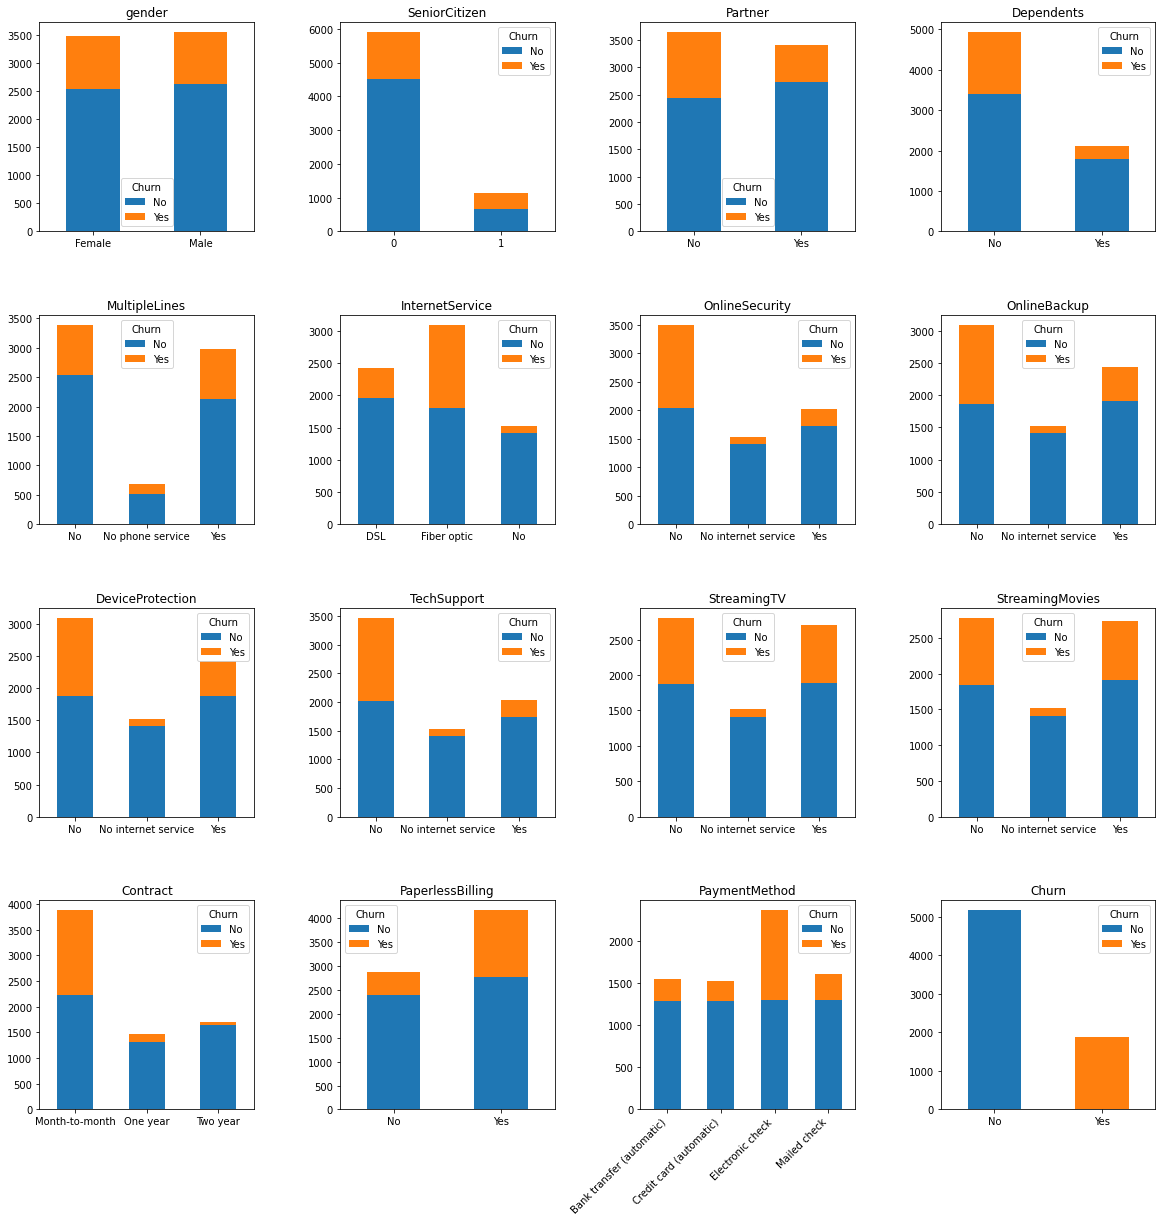

In [ ]:
fig, axes = plt.subplots(4, 4, figsize = (20, 20))

j=0

for column_name in ["gender", "SeniorCitizen", "Partner", "Dependents", "MultipleLines", "InternetService", "OnlineSecurity",
                    "OnlineBackup", "DeviceProtection",	"TechSupport", "StreamingTV", "StreamingMovies", "Contract",
                    "PaperlessBilling", "PaymentMethod", "Churn"]:
  rotation = 0 if column_name != "PaymentMethod" else 45

  df.groupby([column_name, "Churn"]).size().unstack().plot(kind = "bar", legend = True, title = column_name,
                                                           stacked = True, rot = rotation, ax = axes[int(j/4), j%4]).xaxis.label.set_visible(False)

  if column_name == "PaymentMethod":    
    plt.setp(axes[int(j/4), j%4].get_xticklabels(), horizontalalignment = "right")

  j+=1

plt.subplots_adjust(wspace = 0.4, hspace = 0.4)
plt.show()

A vast majority of leaving customers have no dependents, an internet service (DSL or Fiber optic) and a month-to-month contract.

Gender looks completely unrelated by whether the person leaves or not. Also having a partner does not seem to have a big influence, although a small majority of people without a partner tends to churn.

`Churn` has about 26% of "Yes" values. To be fair, this is a quite unrealistic situation for a real life company, especially the big ones, since only a small amount of customers is expected to churn at the end of a specific time frame.

These qualitative variables need to be enginereed. Many of them take a boolean value (respectively "No" and "Yes") so these are converted to an integer value (respectively 0 and 1). Also, qualitative variables with multiple possible outcomes are one-hot encoded and replaced with dummy variables.

In [ ]:
df_target = df["Churn"]

df.gender = df.gender.apply(lambda x: 1 if x == "Male" else 0)
df.rename(columns={"gender":"genderMale"}, inplace = True)

for column_name in ["Partner", "Dependents", "PhoneService", "OnlineSecurity", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "PaperlessBilling", "Churn"]:
  df[column_name] = df[column_name].apply(lambda x: 1 if x == "Yes" else 0)

df = pd.get_dummies(df, columns = ["MultipleLines", "InternetService", "Contract", "PaymentMethod"])
df = df.drop("Churn", axis = 1)

In [ ]:
df.head(15)

,genderMale,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
customerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,0,1,0,1,0,0,1,0,0,0,0,1,29.85,29.85,0,1,0,1,0,0,1,0,0,0,0,1,0
5575-GNVDE,1,0,0,0,34,1,0,0,1,0,0,0,0,56.95,1889.50,1,0,0,1,0,0,0,1,0,0,0,0,1
3668-QPYBK,1,0,0,0,2,1,0,1,0,0,0,0,1,53.85,108.15,1,0,0,1,0,0,1,0,0,0,0,0,1
7795-CFOCW,1,0,0,0,45,0,0,0,1,1,0,0,0,42.30,1840.75,0,1,0,1,0,0,0,1,0,1,0,0,0
9237-HQITU,0,0,0,0,2,1,0,0,0,0,0,0,1,70.70,151.65,1,0,0,0,1,0,1,0,0,0,0,1,0
9305-CDSKC,0,0,0,0,8,1,0,0,1,0,1,1,1,99.65,820.50,0,0,1,0,1,0,1,0,0,0,0,1,0
1452-KIOVK,1,0,0,1,22,1,0,1,0,0,1,0,1,89.10,1949.40,0,0,1,0,1,0,1,0,0,0,1,0,0
6713-OKOMC,0,0,0,0,10,0,0,0,0,0,0,0,0,29.75,301.90,0,1,0,1,0,0,1,0,0,0,0,0,1
7892-POOKP,0,0,1,0,28,1,0,0,1,1,1,1,1,104.80,3046.05,0,0,1,0,1,0,1,0,0,0,0,1,0


This is what the first 15 rows look like after the feature engineering.

Train and test sets were not provided, so they are created splitting the data, following the Pareto principle.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, df_target, train_size = 0.8, stratify = df_target, random_state = 42)

## 2. Model

An Extreme Gradient Boosting (XGBoost) model is picked to deal with this supervised learning problem. This model is widely used by data scientists to achieve state-of-the-art results on many machine learning challenges.

Some of its best hyperparameters are estimated via a grid search using a 5-folds cross validation.

In [ ]:
hyperparams = {"n_estimators":[100, 1000, 10000], "max_depth":[3, 4, 5], "learning_rate":[0.1, 0.01, 0.001],
               "scale_pos_weight":[1, sum(y_train == 0)/sum(y_train == 1), 3, 10, 50, 100]}

xgb_model = xgb.XGBClassifier(objective = "binary:logistic", n_jobs = -1, seed = 42)

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

randsearch = GridSearchCV(estimator = xgb_model, param_grid = hyperparams, n_jobs = -1, cv = cv, verbose = 1, scoring = "roc_auc")

randsearch.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 41.9min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 109.4min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 201.6min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 214.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:lo...
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=42, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 5],
  

In [ ]:
best_params = randsearch.best_params_
print(best_params)
best_score = randsearch.best_score_
print(best_score)
xgb_model = randsearch.best_estimator_
print(xgb_model)

{'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10000, 'scale_pos_weight': 1}
0.8480098567346529
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.001, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=10000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.8, verbosity=1)


Best hyperparameters are found, so the model can be estimated.

In [ ]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.001, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=10000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.8, verbosity=1)

## 3. Results

Model performance is measured taking into account the AUC value.

Cross validation is used again, this time to evaluate the performance of the model on the train set.

In [ ]:
pred_train = cross_val_predict(xgb_model, X_train, y_train, cv = cv, n_jobs = -1, method = "predict_proba")
auc_train = roc_auc_score(y_train, pred_train[:,1])
print("AUC for train set (with CV):", auc_train)

AUC for train set (with CV): 0.847534303359592


AUC is now computed for the test set too.

In [ ]:
pred_test = xgb_model.predict_proba(X_test)

auc_test = roc_auc_score(y_test, pred_test[:,1])
print("AUC for test set:", auc_test)

AUC for test set: 0.8457335503371308


AUC values are pretty similar for train and test sets. There is no overfitting, so the model was able to being reliable with new data too. Moreover, AUC values are not close to 1, but still fine to guarantee a reasonable performance.

Finally, ROC curve for the test set is plotted.

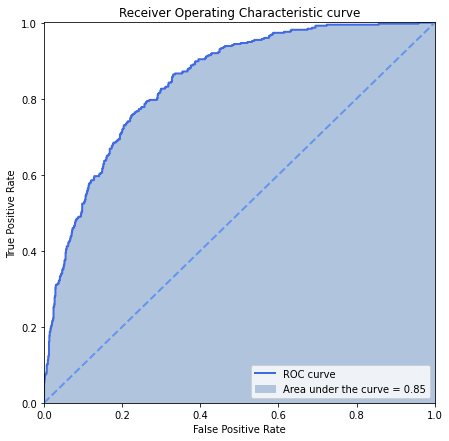

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, pred_test[:,1])
auc_test = auc(fpr, tpr)

plt.figure(figsize = (7, 7))
line_width = 2
plt.plot(fpr, tpr, color = "royalblue", lw = line_width, label = "ROC curve")
plt.fill_between(x = fpr, y1 = 0, y2 = tpr, color = "lightsteelblue", label = "Area under the curve = %0.2f" % auc_test)
plt.plot([0, 1], [0, 1], color = "cornflowerblue", lw = line_width, linestyle = "--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.001])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic curve")
plt.legend(loc = "lower right")
plt.show()

## 4. Final words

After an extensive data exploration that led to getting many insights on customers, and a necessary pre-processing that ended with a change in the structure of the data, an Extreme Gradient Boosting model was built.

The model was able to deliver a solid performance, and, more importantly, to provide consistent results between the train and the test sets. Generally speaking, predicting customers behavior to retain them is challenging for many companies. A predictive model could provide a useful tool to a decision maker, in order to develop a strategy to retain the customers that are more likely to leave.